### Dual formulation

I solve here the smoothed dual problem : 
$$
\max_{\mathbf{\alpha} \in \mathbf{R}^m, \mathbf{\beta} \in \mathbf{R}^n} \mathbf{\alpha}^{\top} \mathbf{a} + \mathbf{\beta}^{\top} b - \sum\limits_{j = 1}^{n}\delta_{\Omega}(\mathbf{\alpha} + \beta_j \mathbf{1}_m - \mathbf{c}_{\cdot,j})
$$
A L-BFGS method is applied.

In [1]:
import numpy as np
import PIL
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import scipy as sc
from scipy.sparse import csr_matrix, identity
from sklearn.metrics.pairwise import euclidean_distances
import cvxpy as cp
import sys
import time

In [2]:
FNAME = 'drapeau.jpg'
img_ref = Image.open(FNAME).convert('RGB')
x = np.array(img_ref)
r_ref, g_ref, b_ref= np.rollaxis(x, axis = -1)
x_ref = np.dstack([r_ref, g_ref, b_ref])
img_ref = Image.fromarray(x_ref, 'RGB')

In [3]:
FNAME = 'arbre.jpg'
img_src = Image.open(FNAME).convert('RGB')
x = np.array(img_src)
r_src, g_src, b_src = np.rollaxis(x, axis = -1)
x_src = np.dstack([r_src, g_src, b_src])
img_src = Image.fromarray(x_src, 'RGB')

In [4]:
width_ref , length_ref,_= np.shape(x_ref)
width_src, length_src,_ = np.shape(x_src)

N_src = width_src*length_src
N_ref = width_ref*length_ref

Orthogonal projection on simplex

In [5]:
###
def find(Y):
    """
    Returns the index sought for finding the root 

    Args : 
        Y : vector we want to project on the unitary simplex (list n x 1)
    """
    for i in range(1,len(Y)): #We start from the largest element
        if np.sum([Y[j] - Y[i] for j in range(i)]) - 1 >= 0:
            return i
    return -1

def root(Y):
    """
    Returns the root of h, i.e the optimal Lagrange multiplier of the kkt conditions
    """
    Y_p = np.sort(Y) #We sort elements from smaller to larger
    Y_p = np.flip(Y_p)
    i = find(Y_p)
    if i >= 0:
        return (np.sum(Y_p[:i]) - 1)/i
    else:
        return (np.sum(Y) - 1)/len(Y)

def max(a,b):
    if a<b: 
        return b
    return a

def proj_simplexe(Y): 
    mu = root(Y)
    if mu == 'non feasible':
        return Y
    else:
        return [max(Y[i] - mu, 0) for i in range(len(Y))]

In [6]:
def entropy(Y,gamma):
    return np.sum([Y[i]*np.log(Y[i])*gamma for i in range(len(Y))])

def conjug_entropy(x, gamma):
    return gamma*np.sum([np.exp(i/gamma - 1) for i in x])

def grad_conjug_entropy(x, gamma):
    return np.array([np.exp(i/gamma - 1) for i in x])

def max_entropy(x,gamma,b):
    return gamma*np.log(np.sum([np.exp(i/gamma) for i in x])) - np.log(b)*gamma

def grad_max_entropy(x, gamma):
    L = [np.exp(i/gamma) for i in x]
    return np.array(L/np.sum(L))
#----------------------------------------------------------------------------------------------
def squared_norm(x,gamma):
    return np.linalg.norm(x)**2 * gamma/2

def conjug_squared_norm(x,gamma):
    return 1/(2*gamma)*np.sum([x[i]**2 for i in range(len(x)) if x[i] > 0])

def grad_conjug_squared_norm(x,gamma):
    return np.maximum(x,0)/gamma

def grad_max_squared_norm(x,gamma,b):
    return proj_simplexe(x/(gamma*b))

def max_squared_norm(x,gamma,b):
    y = grad_max_squared_norm(x,gamma, b)
    return np.dot(x,y) - gamma*b/2*np.dot(y,y)


In [7]:
colors_ref = np.empty((width_ref*length_ref,3))
j = 0
for i in range(width_ref*length_ref):
    j = i%length_ref #number of column
    l = i//length_ref #number of row
    colors_ref[i,0] = r_ref[l,j]
    colors_ref[i,1] = g_ref[l,j]
    colors_ref[i,2] = b_ref[l,j]

colors_src = np.empty((width_src*length_src,3))
j = 0
for i in range(width_src*length_src):
    j = i%length_src #width
    l = i//length_src
    colors_src[i,0] = r_src[l,j]
    colors_src[i,1] = g_src[l,j]
    colors_src[i,2] = b_src[l,j] 

Text(0.5, 0, 'N° clusters')

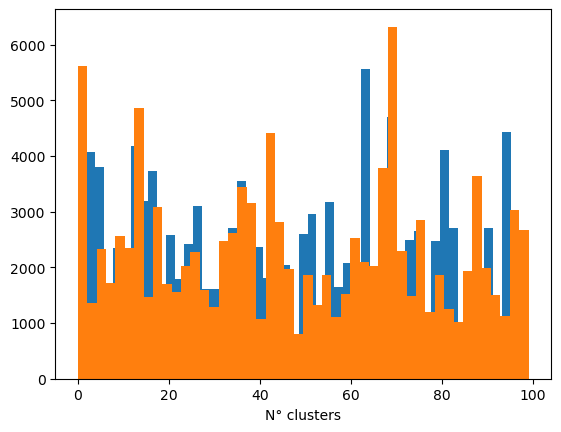

In [8]:
n_src, n_ref = 100, 100 #number of clusters
k_means_color_ref = KMeans(n_clusters = n_ref, random_state = 0, n_init = "auto").fit(colors_ref)
label_ref = k_means_color_ref.labels_
hist_ref = np.histogram(label_ref, bins = n_ref)
plt.hist(label_ref, bins = "auto")

k_means_color_src = KMeans(n_clusters = n_src, random_state = 0, n_init = "auto").fit(colors_src)
label_src = k_means_color_src.labels_
hist_src = np.histogram(label_src, bins = n_src)
plt.hist(label_src, bins = "auto")
plt.xlabel('N° clusters')

In [9]:
X = [i for i in range(10)]
a = [hist_ref[0][i]/N_ref for i in range(n_ref)]
b = [hist_src[0][i]/N_src for i in range(n_src)]

Building of matrix $(C_{i,j})_{i,j \in \llbracket 1,m\rrbracket \times \llbracket 1,n \rrbracket} = (d(\hat{\mathbf{x}}_i^{\text{ref}}, \hat{\mathbf{x}}_j^{\text{src}}))_{i,j \in \llbracket 1,m\rrbracket \times \llbracket 1,n \rrbracket}$ where $\hat{\mathbf{x}}_i^{\text{ref}}$ is the i-th centroid  of the reference image and $\hat{\mathbf{x}}_j^{\text{src}}$ is the j-th centroid of the source image.

In [54]:
cluster_center_ref = k_means_color_ref.cluster_centers_/256 #scaling
cluster_center_src = k_means_color_src.cluster_centers_/256 #scaling

def dist(x,y):
    """
    return euclidian distance between x and y, with a more stable implementation
    Outputs : 
        ||x - y||^2
    """
    return np.dot(x,x) - 2*np.dot(x,y) + np.dot(y,y)

c = np.empty((n_ref*n_src))
for i in range(n_ref): #Nombre de lignes
    for j in range(n_src): #Nombre de colonnes
        c[i + j * n_ref] = dist(cluster_center_src[j], cluster_center_ref[i])

c_p = euclidean_distances(cluster_center_ref, cluster_center_src, squared=True)

In [55]:
def mean_vector(T,y,n_src,n_ref):
    """
    new color after transport of y with T
    Args:
        T : transport plan (list nm)
        y : cluster of the source (or reference) image (int)
        n_src : number of cluster of the source image (int)
        n_ref : number of cluster of the reference image (int)
    Outputs : 
        solution of the barycentric problem projection
    """
    x = np.empty((n_ref,3))
    for i in range(n_ref):
        t = 0
        for j in range(n_src):
            t += T[i + j*n_ref]*y[j]
        x[i] = t/np.sum([T[i + j*n_ref] for j in range(n_src)])
    return x


def mean_tensor(T,y,n_src,n_ref):
    """
    new color after transport of y with T
    Args:
        T : transport plan (list n x m)
        y : cluster of the source (or reference) image (int)
        n_src : number of cluster of the source image (int)
        n_ref : number of cluster of the reference image (int)
    Outputs : 
        solution of the barycentric problem projection
    """
    x = np.empty((n_ref,3))
    for i in range(n_ref):
        for j in range(n_src):
            x[i] += T[i,j]*y[j]
        x[i] /= np.sum(T[i,:])
    return x

In [142]:
gamma_L = [1e-3,1e-2,1e-1,1e0,1e1] #try for differents gamma
Time_ent = [37.4, 17.5, 17.842004776000977, 37.8, 34.26097750663757]
Time_l2 = [31.932182550430298, 8.77163553237915, 3.7722818851470947, 3.1, 1.24]
gamma = gamma_L[0]
def function(x):
    """
    smoothed dual problem for entropic regularization
    Args : 
        x : contains alpha and beta (list n_ref x n_src)
    Outputs : 
        return the function to maximize evaluated at x
    """
    alpha = x[:n_ref]
    beta = x[n_ref:]
    one = np.ones(n_ref)
    delta = 0
    grad_alpha = a.copy()
    grad_beta = b.copy()
    for i in range(n_src):
        inter = alpha + beta[i]*one - c[n_ref*i : n_ref*(i + 1)]
        inti = conjug_entropy(inter, gamma)
        delta += inti
        grad_alpha -= grad_conjug_entropy(inter, gamma)
        grad_beta[i] -= np.sum(grad_conjug_entropy(inter, gamma))
    fun = (np.dot(alpha,a) + np.dot(beta,b) - delta)
    ###
    #Compare with the optimal transportation plan to see how fast it converges
    t_sol = np.empty((n_ref*n_src))
    for i in range(n_src):
        t_sol[i*n_ref: (i + 1)*n_ref] = grad_conjug_entropy(alpha + beta[i]*np.ones(n_ref) - c[n_ref*i : n_ref*(i + 1)], gamma)
    ##
    grad = np.concatenate((grad_alpha, grad_beta))
    return -fun, -grad #there is a - Because I want to maximize

In [143]:
x0 = np.zeros((n_src + n_ref)) #Starting point is very important
start = time.time()
res = sc.optimize.minimize(function,x0, method = 'BFGS', jac = True)
end = time.time()
print(end - start)
alpha = res.x[:n_ref]
beta = res.x[n_ref:]
print(res)
t_sol = np.empty((n_ref*n_src))
for i in range(n_src):
    t_sol[i*n_ref: (i + 1)*n_ref] = grad_conjug_entropy(alpha + beta[i]*np.ones(n_ref) - c[n_ref*i : n_ref*(i + 1)], gamma)

31.795931100845337
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -0.041807718346133144
        x: [-9.942e-02  3.801e-02 ...  1.822e-02 -3.803e-01]
      nit: 328
      jac: [-1.417e-07 -2.146e-06 ...  3.170e-06  7.494e-07]
 hess_inv: [[ 3.385e-01 -3.929e-02 ...  6.755e-02  3.992e-01]
            [-3.929e-02  1.882e-01 ... -1.397e-01  1.010e-01]
            ...
            [ 6.755e-02 -1.397e-01 ...  3.531e-01  4.107e-02]
            [ 3.992e-01  1.010e-01 ...  4.107e-02  3.901e+00]]
     nfev: 347
     njev: 347


In [144]:
def from_vector_to_tensor(t,m,n):
    """
    Transform a vector of size mn into a m times n tensor columnwise like it is done for t and c
    Args : 
        t : vector to transform
        m : number of cluster of reference image
        n : number of cluster of source image
    Output : 
    The square matrix equivalent to t in columnwise setting
    """
    T = np.empty((m,n))
    for i in range(m*n):
        j = i//m
        l = i%m
        T[l,j] = t[i]
    return T
T = from_vector_to_tensor(t_sol, n_ref, n_src)
C = from_vector_to_tensor(c,n_ref, n_src)


In [145]:
def equality(m,n):
    """
    Build here all the equality constraints for regular OT
    Args : 
        m : number of constraints (i.e number of cluster colors) for reference image (int n_ref)
        n : number of constraints (i.e number of cluster colors) for source image (int n_ref)
    Output:
        Matrix for first set of constraints A1 and second set of constraints
    """
    A1 = np.zeros((m,n*m)) #equality for a
    A2 = np.zeros((n,n*m)) #equality for b

    for j in range(m):
        for i in range(0,n*m,m):
            A1[j, j + i] = 1
    k = 0
    for j in range(n):
        A2[j,k: k + m] = 1
        k += m
    return A1,A2


d = np.concatenate((a,b))
t = cp.Variable(n_ref*n_src)
A1,A2 = equality(n_ref,n_src)
A = np.concatenate((A1,A2))


In [146]:
cluster_center_new_dual = mean_vector(t_sol,cluster_center_src,n_src,n_ref)

In [147]:
image_n = cluster_center_new_dual[label_ref]

In [148]:
image_new = np.zeros((width_ref, length_ref, 3))
for i in range(width_ref):
    for j in range(length_ref):
        image_new[i,j] = image_n[i*length_ref + j] #row-wise

(-0.5, 399.5, 299.5, -0.5)

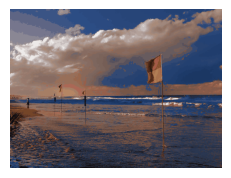

In [149]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(221)
ax.imshow(image_new)
ax.axis("off")

In [116]:
sparsity = (n_ref*n_src - len(T[T > 0]))/(n_ref*n_src) #Percentage of sparsity
sparsity

0.0844

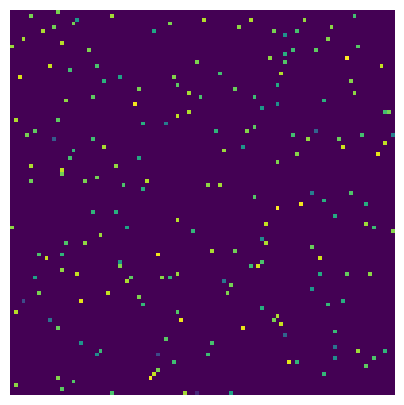

In [66]:
plt.figure(figsize=(5,5))
plt.imshow(np.log(T+1e-5))
plt.axis('off');

Solving regular OT to have $T^\star$ to compare with dual solutions.

In [85]:
d = np.concatenate((a,b))
t = cp.Variable(n_ref*n_src)
A1,A2 = equality(n_ref,n_src)
A = np.concatenate((A1,A2))

In [86]:
prob = cp.Problem(cp.Minimize(c.T@t),
                 [A @ t == d, t >= 0])
prob.solve(solver = 'ECOS')
# Print result.
print("\n The optimal value is", prob.value)
print("A solution t is")
print(t.value)


 The optimal value is 0.047127339320314876
A solution t is
[-7.76034039e-16  1.30526746e-14 -1.62395405e-17 ... -1.20671475e-15
 -1.23944049e-15 -8.42838986e-16]


Plot of $||T_{dual} - T^\star||$

In [69]:
file_path = 'dual.txt'

with open(file_path) as file:
    line_list_norm = file.readlines()
    line_list_norm = [float(item.rstrip()) for item in line_list_norm]

file_path = 'dual_ent.txt'

with open(file_path) as file:
    line_list_ent = file.readlines()
    line_list_ent = [float(item.rstrip()) for item in line_list_ent]


file_path = 'semi_dual.txt'

with open(file_path) as file:
    line_list_semi_n = file.readlines()
    line_list_semi_n = [float(item.rstrip()) for item in line_list_semi_n]

file_path = 'semi_dual_ent.txt'

with open(file_path) as file:
    line_list_semi_ent = file.readlines()
    line_list_semi_ent = [float(item.rstrip()) for item in line_list_semi_ent]

(0.003, 1.0)

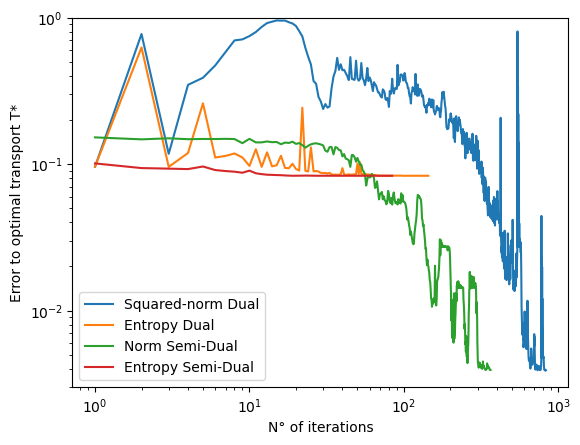

In [70]:
n_iter_n = 831
N = np.linspace(1,n_iter_n,n_iter_n)
plt.loglog(N,line_list_norm, label = 'Squared-norm Dual')

n_iter_ent = 144
N_ent = np.linspace(1,n_iter_ent,n_iter_ent)
plt.loglog(N_ent,line_list_ent, label = "Entropy Dual")

n_iter_n = 364
N = np.linspace(1,n_iter_n,n_iter_n)
plt.loglog(N,line_list_semi_n, label = 'Norm Semi-Dual')

n_iter_ent = 84
N_ent = np.linspace(1,n_iter_ent,n_iter_ent)
plt.loglog(N_ent,line_list_semi_ent, label = 'Entropy Semi-Dual')

plt.legend()

plt.xlabel('N° of iterations')
plt.ylabel('Error to optimal transport T*')

plt.xlim()
plt.ylim(3e-3,1e0)

In [93]:
print(np.linalg.norm(np.dot(A,t_sol) - d)/np.linalg.norm(d)) #erreur relative vis-à-vis de la contrainte d'égalité
print(np.linalg.norm(t_sol - t.value))

0.000204899220191954
0.08408442508541715


In [94]:
Cons_error_ent = [0.0001613417447475963, 0.00017851143163619278, 0.00013077620516464223, 0.00021928121980894073, 0.00025917965760377613]
error_opt_ent = [0.0498204622164831, 0.08314984943096997, 0.09256197728339885, 0.09431087945001053, 0.09452198809414732]

Cons_error_n = [0.00019430382574581585, 0.0001689875791128267, 0.0002378596918816517, 0.00018640844222733856, 0.000204899220191954]
error_opt_n = [3.065018607265775e-05, 0.003923210641348376, 0.03714426047190415, 0.06750391345501992, 0.08408442508541715]

def ent(a):
    entropy = 0
    for i in a:
        entropy += -i*np.log(i)
    return entropy

ent_a = ent(a)
ent_b = ent(b)
#For entropy regularization
L_e = np.dot((ent_a + ent_b), gamma_L)
U_e = np.dot(max(ent_a,ent_b),gamma_L)

#For squared-norm regularization
L_n = np.dot(1/2*np.sum([(a[i]/n_src + b[j]/n_ref - 1/(n_src*n_ref))**2 for i in range(len(a)) for j in range(len(b))]),gamma_L)
U_n = np.dot((np.min((np.linalg.norm(a)**2, np.linalg.norm(b)**2))),gamma_L)

value_ent = [0.041807718346133144, -0.0177616070631288, -0.7362667066331408, -8.513380524938997, -86.97643520943326]
value_l2 = [0.04713193073505928, 0.04717306770773151, 0.04751422362372201, 0.049440365254992916, 0.05769053761293517]

value_error_ent = np.abs(value_ent - prob.value)
value_error_l2 = value_l2 - prob.value

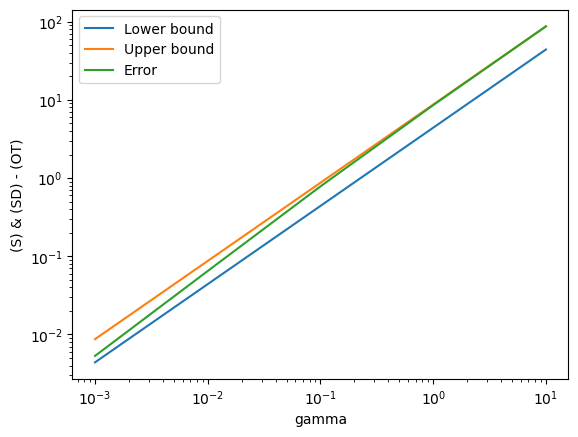

In [100]:
plt.loglog(gamma_L,U_e, label = 'Lower bound')
plt.loglog(gamma_L,L_e, label = 'Upper bound')
plt.loglog(gamma_L,value_error_ent, label = 'Error')
plt.xlabel('gamma')
plt.ylabel('(S) & (SD) - (OT)')
plt.legend()

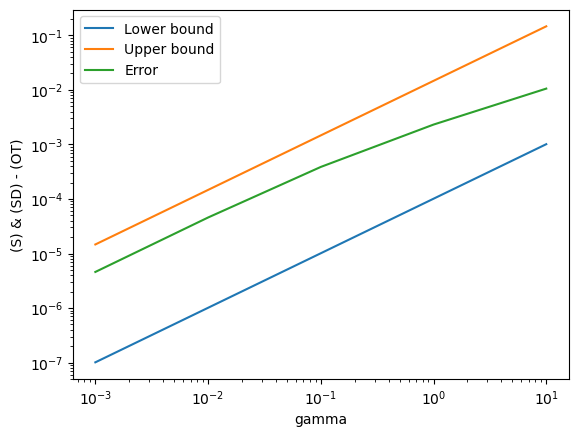

In [99]:
plt.loglog(gamma_L,L_n, label = 'Lower bound')
plt.loglog(gamma_L,U_n, label = 'Upper bound')
plt.loglog(gamma_L,value_error_l2, label = 'Error')
plt.xlabel('gamma')
plt.ylabel('(S) & (SD) - (OT)')
plt.legend()

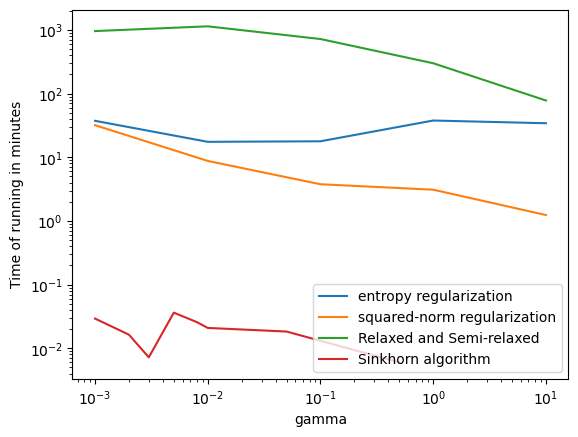

In [167]:
Time_ent = [37.4, 17.5, 17.842004776000977, 37.8, 34.26097750663757]
gamma_L2 = [1e-3,2e-3,3e-3,5e-3,8e-3,1e-2,5e-2,5e-1]
Time_l2 = [31.932182550430298, 8.77163553237915, 3.7722818851470947, 3.1, 1.24]
Time_rel = [16*60, 19*60, 12*60, 5*60, 1.3*60]
Time_sinkhorn = [0.029334306716918945,
 0.016376018524169922,
 0.007218360900878906,
 0.036338090896606445,
 0.0258333683013916,
 0.020913362503051758,
 0.018347501754760742,
 0.006028890609741211]
plt.plot(gamma_L, Time_ent, label = 'entropy regularization')
plt.plot(gamma_L, Time_l2, label = 'squared-norm regularization')
plt.plot(gamma_L, Time_rel, label = 'Relaxed and Semi-relaxed ')
plt.plot(gamma_L2, Time_sinkhorn, label = 'Sinkhorn algorithm')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('gamma')
plt.ylabel('Time of running in minutes')
plt.legend()